https://www.kaggle.com/competitions/spaceship-titanic/overview

#Install Essential Framework

In [1]:
! pip install -qq kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
# https://drive.google.com/file/d/1OTrg_aUlEzUUJQIEXyGlJ5d6Tkj-fANk/view?usp=sharing
!gdown --id 1OTrg_aUlEzUUJQIEXyGlJ5d6Tkj-fANk

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OTrg_aUlEzUUJQIEXyGlJ5d6Tkj-fANk
To: /content/kaggle.json
100% 71.0/71.0 [00:00<00:00, 103kB/s]


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c spaceship-titanic

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip -qq /content/spaceship-titanic.zip

replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#Import library

In [8]:
#importing required modules
import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
import os
import torch.optim as optim
from PIL import ImageFile
from sklearn.metrics import accuracy_score
import imageio
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
sns.set()

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import math
import pandas as pd


from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

#Check CUDA

In [9]:
#Checking the availability of a GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cpu


#EDA

In [11]:
BACKCOLOR = '#f6f5f5'

In [12]:
from IPython.core.display import HTML
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [13]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines[['top', 'right']].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [14]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=df_train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines[['top','right']].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

## Train Data

In [15]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [17]:
print(f'Number of rows in train data: {df_train.shape[0]}')
print(f'Number of columns in train data: {df_train.shape[1]}')
print(f'Number of values in train data: {df_train.count().sum()}')
print(f'Number missing values in train data: {sum(df_train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


In [18]:
print(df_train.isna().sum().sort_values(ascending = False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [19]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [20]:
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [21]:
multi_table([pd.DataFrame(df_train[i].value_counts()) for i in df_train.columns if i != 'Age'])

,PassengerId
0001_01,1
6136_01,1
6141_01,1
6139_06,1
6139_05,1
...,...
3126_01,1
3124_03,1
3124_02,1
3124_01,1


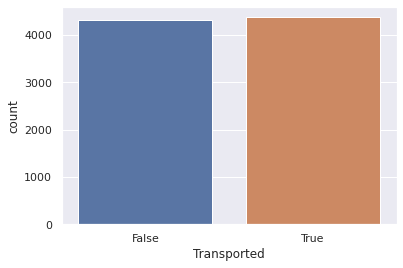

In [22]:
sns.countplot(x='Transported', data=df_train);

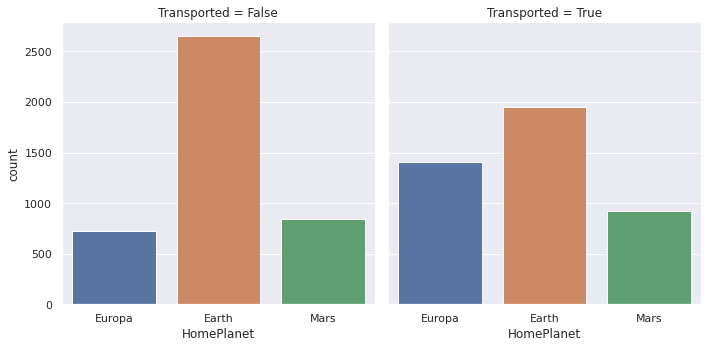

In [23]:
sns.catplot(x='HomePlanet', col='Transported', kind='count', data=df_train);

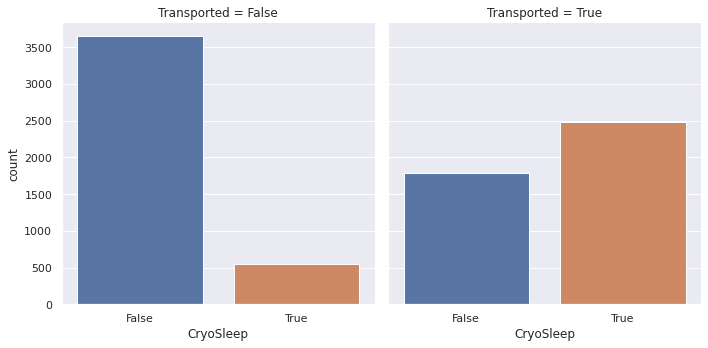

In [24]:
sns.catplot(x='CryoSleep', col='Transported', kind='count', data=df_train);

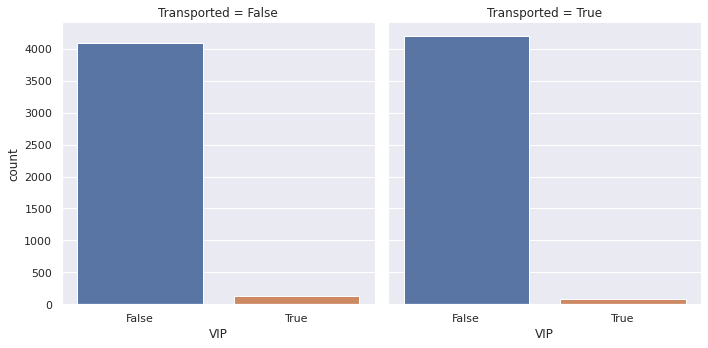

In [25]:
sns.catplot(x='VIP', col='Transported', kind='count', data=df_train);

## Test Data

In [26]:
df_test = pd.read_csv('/content/test.csv')
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [28]:
print(f'Number of rows in train data: {df_test.shape[0]}')
print(f'Number of columns in train data: {df_test.shape[1]}')
print(f'Number of values in train data: {df_test.count().sum()}')
print(f'Number missing values in train data: {sum(df_test.isna().sum())}')

Number of rows in train data: 4277
Number of columns in train data: 13
Number of values in train data: 54484
Number missing values in train data: 1117


In [29]:
print(df_test.isna().sum().sort_values(ascending = False))

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


In [30]:
df_test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [31]:
df_test.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

In [32]:
multi_table([pd.DataFrame(df_test[i].value_counts()) for i in df_test.columns if i != 'Age'])

,PassengerId
0013_01,1
6288_02,1
6269_01,1
6269_02,1
6269_03,1
...,...
3072_01,1
3074_01,1
3075_01,1
3077_01,1


## Concat Data

In [33]:
all_data = pd.concat([df_train, df_test], axis=0)
all_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [34]:
all_data.head(10).style.background_gradient()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.000000,False,0.000000,483.000000,0.000000,291.000000,0.000000,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.000000,False,42.000000,1539.000000,3.000000,0.000000,0.000000,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.000000,False,0.000000,0.000000,0.000000,0.000000,nan,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.000000,False,0.000000,785.000000,17.000000,216.000000,0.000000,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Erraiam Flatic,True


In [35]:
print(f'train size : {df_train.shape[0]} x {df_train.shape[1]}')
print(f'test size : {df_test.shape[0]} x {df_test.shape[1]}')
print(f'total size : {all_data.shape[0]} x {all_data.shape[1]}')

train size : 8693 x 14
test size : 4277 x 13
total size : 12970 x 14


In [36]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [37]:
all_data.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [38]:
multi_table([pd.DataFrame(all_data[i].value_counts()) for i in all_data.columns if i != 'Age'])

,PassengerId
0001_01,1
9227_03,1
9220_01,1
9220_02,1
9220_03,1
...,...
4610_01,1
4611_01,1
4612_01,1
4613_01,1


In [39]:
nominal_vars = ['HomePlanet', 'CryoSleep', 'Cabin', 'Desination', 'VIP', 'Name']
continuous_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
target = 'Transported'

In [40]:
train_st = df_train[continuous_vars].describe()
test_st = df_test[continuous_vars].describe()
all_st = all_data[continuous_vars].describe()
multi_table([all_st, train_st, test_st])

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000
,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000


Missing Value

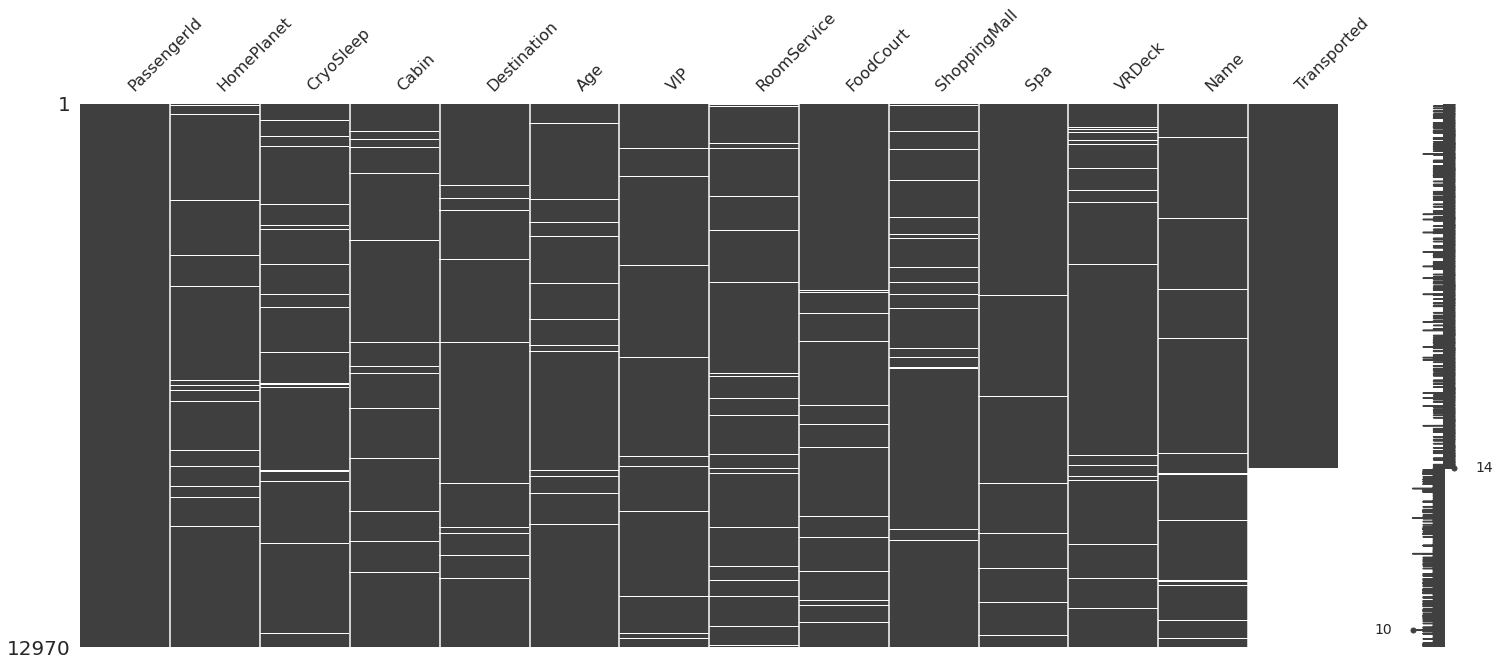

In [41]:
import missingno as msno
msno.matrix(all_data)

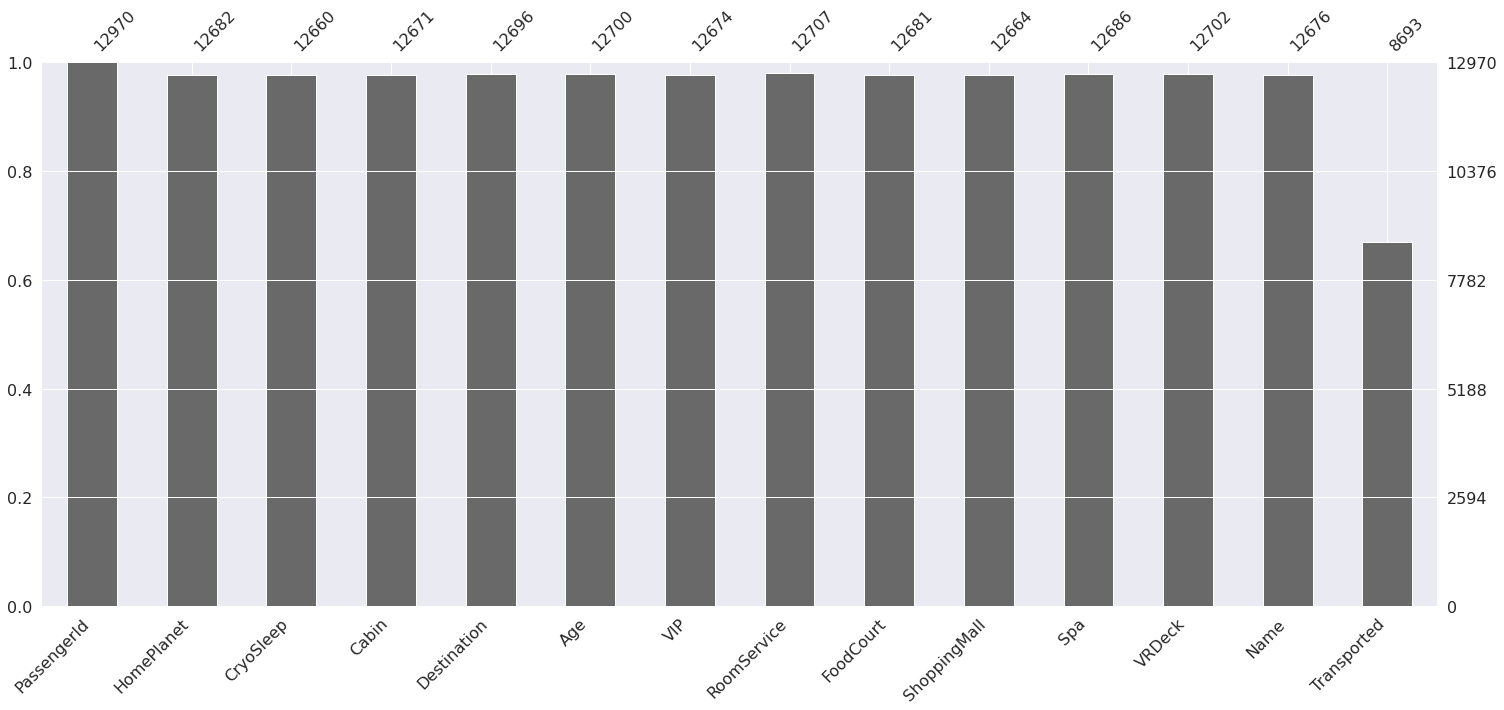

In [42]:
msno.bar(all_data)

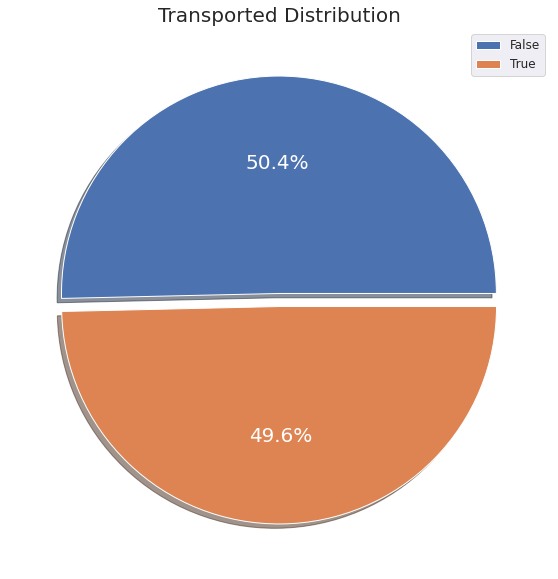

In [43]:
plt.subplots(figsize=(25, 10))
plt.pie(df_train.Transported.value_counts(), shadow=True, explode=[.03,.03], autopct='%1.1f%%', textprops={'fontsize': 20, 'color': 'white'})
plt.title('Transported Distribution', size=20)
plt.legend(['False', 'True'], loc='best', fontsize=12)
plt.show()

#Preprocessing

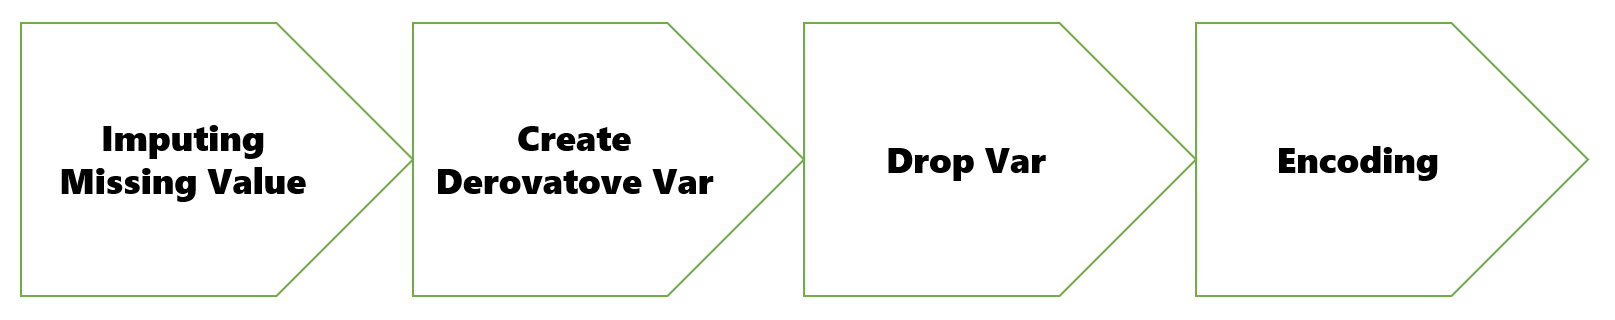

Imputing Missing values

In [44]:
# Replace categorical variables with specific values (False, None) or freeest values.
all_data['CryoSleep'].fillna(False, inplace=True)
all_data['Cabin'].fillna('None', inplace=True)
all_data['VIP'].fillna(all_data.VIP.mode()[0], inplace=True)
all_data['HomePlanet'].fillna(all_data.HomePlanet.mode()[0], inplace=True)
all_data['Destination'].fillna(all_data.Destination.mode()[0], inplace=True)

# Replace continuous variables with specific values (0) or averages.
all_data['Age'].fillna(all_data.Age.mean(), inplace=True)
all_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] =\
all_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

In [45]:
all_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,Earth,False,None,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,28.771969,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,Europa,False,D/297/P,TRAPPIST-1e,28.771969,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN



Create Derivative variable

In [46]:
# As mentioned earlier, create a new variable by decomposing strings in Cabin and PassengerId.
all_data['Deck'] = all_data.Cabin.apply(lambda x:str(x)[:1])
all_data['Side'] = all_data.Cabin.apply(lambda x:str(x)[-1:])
all_data['PassengerGroup'] = all_data['PassengerId'].apply(lambda x: x.split('_')[0])
all_data['PassengerNo'] = all_data['PassengerId'].apply(lambda x: x.split('_')[1])

# Generate new variables based on the amount of money used for various services.
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data['Spa'] + all_data['VRDeck']
all_data['PctRoomService'] = all_data['RoomService']/all_data['TotalSpend']
all_data['PctFoodCourt'] = all_data['FoodCourt']/all_data['TotalSpend']
all_data['PctShoppingMall'] = all_data['ShoppingMall']/all_data['TotalSpend']
all_data['PctSpa'] = all_data['Spa']/all_data['TotalSpend']
all_data['PctVRDeck'] = all_data['VRDeck']/all_data['TotalSpend']

# Create new variables by dividing age groups.
all_data['AgeBin'] = 7
for i in range(6):
    all_data.loc[(all_data.Age >= 10*i) & (all_data.Age < 10*(i + 1)), 'AgeBin'] = i

In [47]:
# Replaces the missing value that occurred when generating the derived variable.
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
all_data[fill_cols] = all_data[fill_cols].fillna(0)

Drop Variables

In [48]:
# Remove unnecessary variables.
all_data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

Encoding

In [49]:
for col in all_data.columns[all_data.dtypes == object]:
    if col != 'Transported':
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col])
        
all_data['CryoSleep'] = all_data['CryoSleep'].astype('int')
all_data['VIP'] = all_data['VIP'].astype('int')

In [50]:
all_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Side,PassengerGroup,PassengerNo,TotalSpend,PctRoomService,PctFoodCourt,PctShoppingMall,PctSpa,PctVRDeck,AgeBin
0,1,0,2,39.000000,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3
1,0,0,2,24.000000,0,109.0,9.0,25.0,549.0,44.0,...,1,1,0,736.0,0.148098,0.012228,0.033967,0.745924,0.059783,2
2,1,0,2,58.000000,1,43.0,3576.0,0.0,6715.0,49.0,...,1,2,0,10383.0,0.004141,0.344409,0.000000,0.646730,0.004719,5
3,1,0,2,33.000000,0,0.0,1283.0,371.0,3329.0,193.0,...,1,2,1,5176.0,0.000000,0.247875,0.071677,0.643161,0.037287,3
4,0,0,2,16.000000,0,303.0,70.0,151.0,565.0,2.0,...,1,3,0,1091.0,0.277727,0.064161,0.138405,0.517874,0.001833,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,34.000000,0,0.0,0.0,0.0,0.0,0.0,...,1,9265,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3
4273,0,0,2,42.000000,0,0.0,847.0,17.0,10.0,144.0,...,2,9268,0,1018.0,0.000000,0.832024,0.016699,0.009823,0.141454,4
4274,2,1,0,28.771969,0,0.0,0.0,0.0,0.0,0.0,...,0,9270,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2
4275,1,0,2,28.771969,0,0.0,2680.0,0.0,0.0,523.0,...,0,9272,0,3203.0,0.000000,0.836716,0.000000,0.000000,0.163284,2


# Split Train / Test

In [51]:
train, X_test = all_data.iloc[:df_train.shape[0]], all_data.iloc[df_train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

# Model pycaret

In [52]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


In [53]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [54]:
# Classification task
from pycaret.classification import *

s = setup(data=train,
          session_id=7010,
          target='Transported',
          train_size=0.99,
          # fold_strategy='stratifiedkfold',
          fold=5,
          fold_shuffle=True,
          silent=True,
          ignore_low_variance=True,
          remove_multicollinearity = True,
          normalize = True,
          normalize_method = 'robust',)

,Description,Value
0,session_id,7010
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(8693, 22)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [55]:
top4 = compare_models(n_select=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8076,0.8998,0.8141,0.8058,0.8098,0.6151,0.6154,0.350
gbc,Gradient Boosting Classifier,0.8012,0.8949,0.8360,0.7835,0.8088,0.6022,0.6037,2.704
rf,Random Forest Classifier,0.7983,0.8816,0.7732,0.8162,0.7940,0.5967,0.5977,2.206
ada,Ada Boost Classifier,0.7963,0.8777,0.8418,0.7736,0.8061,0.5924,0.5950,0.888
lr,Logistic Regression,0.7936,0.8800,0.8293,0.7759,0.8017,0.5871,0.5885,2.614
et,Extra Trees Classifier,0.7907,0.8639,0.7610,0.8114,0.7852,0.5816,0.5829,1.134
ridge,Ridge Classifier,0.7898,0.0000,0.8506,0.7603,0.8028,0.5793,0.5836,0.074
lda,Linear Discriminant Analysis,0.7898,0.8739,0.8506,0.7603,0.8028,0.5793,0.5836,0.096
knn,K Neighbors Classifier,0.7770,0.8501,0.7658,0.7856,0.7755,0.5541,0.5543,1.046
nb,Naive Bayes,0.7727,0.8471,0.8945,0.7211,0.7984,0.5447,0.5616,0.074


In [56]:
top4

[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=7010, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
         

In [57]:
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'Accuracy', verbose=False)

In [60]:
best_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7010, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Predict

In [64]:
df_pred = predict_model(best_model, data=X_test)

In [65]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4277 entries, 0 to 4276
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HomePlanet       4277 non-null   int64  
 1   CryoSleep        4277 non-null   int64  
 2   Destination      4277 non-null   int64  
 3   Age              4277 non-null   float64
 4   VIP              4277 non-null   int64  
 5   RoomService      4277 non-null   float64
 6   FoodCourt        4277 non-null   float64
 7   ShoppingMall     4277 non-null   float64
 8   Spa              4277 non-null   float64
 9   VRDeck           4277 non-null   float64
 10  Deck             4277 non-null   int64  
 11  Side             4277 non-null   int64  
 12  PassengerGroup   4277 non-null   int64  
 13  PassengerNo      4277 non-null   int64  
 14  TotalSpend       4277 non-null   float64
 15  PctRoomService   4277 non-null   float64
 16  PctFoodCourt     4277 non-null   float64
 17  PctShoppingMal

# Submit

In [63]:
submit = pd.read_csv('/content/sample_submission.csv')
submit.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [66]:
y_pred = df_pred.loc[:, ['Label']]

In [67]:
submit['Transported'] = y_pred
submit.to_csv('submission.csv', index=False)
submit

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [68]:
!kaggle competitions submit -c spaceship-titanic -f /content/submission.csv -m "Submit on Colab"

100% 56.3k/56.3k [00:00<00:00, 252kB/s]
Successfully submitted to Spaceship Titanic